(Placeholder for your group #)

(Placeholder for your names)

(Placeholder for your i-numbers)

**Use of genAI tools (e.g. chatGPT), websites (e.g. stackoverflow)**: *list websites where you found code (or other info) as well as include information on how you used genAI tools*

# Data Analysis

# Clinic 2: I heard you are 👀 for a 🏠 in Utrecht 

By completing and delivering the clinic tasks you will know how to:

- Work with real-world, messy datasets that require cleaning and preprocessing  
- Perform exploratory data analysis (EDA) to guide modeling decisions  
- Engineer new features, including spatial and polynomial features  
- Build reusable data processing pipelines in pandas  
- Train and evaluate linear and regularized models using scikit-learn  
- Use cross-validation to select model hyperparameters  
- Interpret models using feature importance techniques  
- Assess fairness by analyzing prediction errors across groups and locations  
- Communicate technical results clearly to both technical and non-technical audiences  

**Important Dates.**

- Clinic 2 release: Fri 06 Feb 2026
- Clinic 2 due: Mon 23 Feb 2026 late night, wildcards available

**Instructions for the deliverable: notebook and video**

1. Executed Notebook (.ipynb) (80 points)

Your notebook should include the parts as here. All cells must be executed and outputs visible. Include answers to all questions and also explain your reasoning and describe any insights.

---
2. Short Video Presentation (up to 3 minutes) (20 points)

Create a short video aimed at a **general (non-technical) audience** in which you explain:

- What problem you were trying to solve
- How you built your model (high level)
- What features mattered most
- Whether the model was fair across neighborhoods
- One key insight or takeaway

You do **not** need to include code in the video but you **should** include figures and plots. Focus on clarity, intuition and real-world implications.

---
🎯 Video Guidelines

- Maximum length: **3 minutes**
- Target audience: non-technical (e.g., city officials, homeowners, journalists)
- You may use slides, screen recording or simple visuals
- Avoid technical jargon as much as possible
- Do **not** use AI-generated voices or AI video generators.  
- The presentation must use **your own voice**.

---
⚖️ Grading Considerations for the Video

The video will be evaluated on:

- Clarity of explanation
- Correctness of interpretation
- Engagement with fairness issues
- Ability to communicate technical results simply

---

📅 Submission Format

- Upload the executed notebook as `.ipynb`
- Upload or link to your video (e.g., unlisted YouTube link, link to some storage space (e.g. google folder), other...)

- **Honor code** applies to these tasks.  
  If you are not certain about an action, consult with Jerry.
 

**A philosophical note from Jerry on using Language Models (LMs)**

You might have thought about it. Are LLMs going to replace data scientists?

*Short answer*: No-one knows for sure. But, I have some hope.


Here are my thoughts, for this clinic but in general as well. In many of our data analysis tasks we have 3 steps.

+ Step 1: Gather context and ask insightful questions. LLMs cannot deeply understand the nuanced desires, abilities, and personalities of complex organizations. At least for now 🙂

+ Step 2: Plan analyses that address your question(s). LLMs can provide advice as you weigh options. But, the choice of "best" analysis is often subjective. Experience matters. That's what people will pay you for in the future, not your ability to run Python.

+ Step 3: Run the analysis. With proper context and instructions, LLMs can help a lot here! But, you must be able to verify outputs. Don't do analysis by "vibes".

# 0. Introduction

In this clinic, we will go through the iterative process of specifying, fitting, and refining a linear regression model using real-world housing data from Utrecht. Dataset is inspired from this [paper](https://ictinstitute.nl/utrecht-housing-dataset-2025/), which you are welcome to read!

In the first part of the assignment, we will guide you through exploratory data analysis (EDA), laying out the thought process that leads to key data cleaning, transformation, and modeling decisions. We will then specify and fit increasingly refined linear models, providing examples of the type of code and workflow expected in the open-response section.

The second part of the assignment is purposefully left open-ended. You will be allowed to build a linear model of your choice (e.g., linear regression, Ridge, Lasso) to better predict housing values.

After completing this clinic, you should feel comfortable with:

1. Working with a real-world dataset that requires cleaning and preprocessing

1. Performing exploratory data analysis to inform modeling decisions

1. Building linear and regularized models using `sklearn`

1. Creating feature engineering pipelines with `pandas`

1. Using cross-validation for model selection and evaluation

1. Interpreting residuals and error metrics

1. Reflecting on fairness implications in predictive models

## Score breakdown

Question | Points
--- | ---
[Question 1](#q1) | 5
[Question 2a](#q2a) | 2
[Question 2b](#q2b) | 2
[Question 3](#q3) | 2
[Question 4](#q4) | 8
[Question 5](#q5) | 35
[Question 6](#q6) | 15
[Question 7](#q7) | 15
Total | 80

This score will be added to the video score (20), scaled down to 1 and that will be your final clinic score.

In [1]:
#necessary imports (edit as you see fit)
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

#to show big values in numbers and not in scientific format
import matplotlib.ticker as mtick
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.use_locale'] = False


## 0.1 The Data

The dataset consists of several hundred residential properties in Utrecht and includes structural, spatial, and energy-related features.

Some of the key variables include, for more details refer to the `codebook.txt`:

```
retailvalue – estimated market value of the property (our main prediction target)

taxvalue – assessed value used for taxation purposes

house-area, lot-area, garden-size – size-related features

bathrooms, buildyear – structural characteristics

energy-eff – energy efficiency indicator

monument – whether the property is a protected historical building

zipcode, x-coor, y-coor – location information
```

Together, these variables describe both the physical properties of homes and aspects related to sustainability and urban geography.

Dataset is not split to training/test but we will use one common seed (to rule all splits).

### 0.1.1 Housing Valuation and Fairness

🌍 In many countries, including the Netherlands, property values are used to determine: property taxes, mortgage conditions, insurance costs.

💰 These values are often estimated using statistical or machine learning models that take into account characteristics such as size, location, and building quality.

🎯 While predictive accuracy is important, valuation models can also have distributional consequences. Systematic overvaluation or undervaluation of homes in certain areas or categories (e.g., energy-efficient homes, historic buildings, or specific neighborhoods) can lead to: higher tax burdens for some residents, unfair advantages for others.

🧪 In this clinic, we will not only aim to build accurate predictive models, but also examine who benefits and who may be harmed by modeling errors.

🏠📊 By analyzing residuals and group-wise error patterns (e.g., by zipcode, energy efficiency or monument status), we will reflect on how fairness can be understood in the context of housing valuation. That will also serve as a good basis for the guest lecture we are going to have on March 9th.

### 📥 Load the dataset

In [2]:
data = pd.read_csv("utrechthousing.csv")

### ✂️ Create train/test split

Since the dataset is not pre-divided into training and test sets, we create our own split. The training set will be used to fit and tune our models, while the test set will be held out to evaluate performance on unseen data. To ensure reproducibility across different runs of the notebook, we fix the random seed before splitting.

In [3]:
# For reproducibility (so everyone gets the same split) ###DO NOT CHANGE
np.random.seed(1983)

# Split: 80% train, 20% test
training_data, testing_data = train_test_split(
    data, 
    test_size=0.2, 
    random_state=1983
)

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# Check sizes
#1516,16
print("Train shape:", training_data.shape)
#379,16
print("Test shape:", testing_data.shape)

# They should sum to full dataset
assert training_data.shape[0] + testing_data.shape[0] == data.shape[0]

# Same columns in both
assert set(training_data.columns) == set(testing_data.columns)

Train shape: (1516, 16)
Test shape: (379, 16)


The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt`.  **You should take some time to familiarize yourself with the codebook before moving forward.** If you find any issues or inconsistencies in the codebook, please report them to us!

In [5]:
training_data.columns.values

array(['id', 'zipcode', 'lot-len', 'lot-width', 'lot-area', 'house-area',
       'garden-size', 'balcony', 'x-coor', 'y-coor', 'buildyear',
       'bathrooms', 'taxvalue', 'retailvalue', 'energy-eff', 'monument'],
      dtype=object)

# 1. Guided Modeling

In the first part of the assignment, we will take you step-by-step through one cycle of the modeling process.  Along the way, we will provide commentary to give you a sense of the thought process that goes into building a model. We give examples on most of the common cases we have explored (EDA, missing values, feature engineering etc.), but feel free to extend this analyses for your final model.

## 1.1 EDA
Naturally, the first thing we want to do is get a feel for our data.  In this section, we will make a series of exploratory visualizations.  The plots we ask you to reproduce here are far from exhaustive. **When you build your own model in the second part of this assignment, you will want to delve deeper into the data.**

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### 1.1.1 Retail-value
We begin by examining a [raincloud plot](https://www.kaggle.com/code/carlmcbrideellis/box-strip-violin-raincloud-plot) (yet another name for a combination of a KDE, a boxplot, and a boxplot all-in-one) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

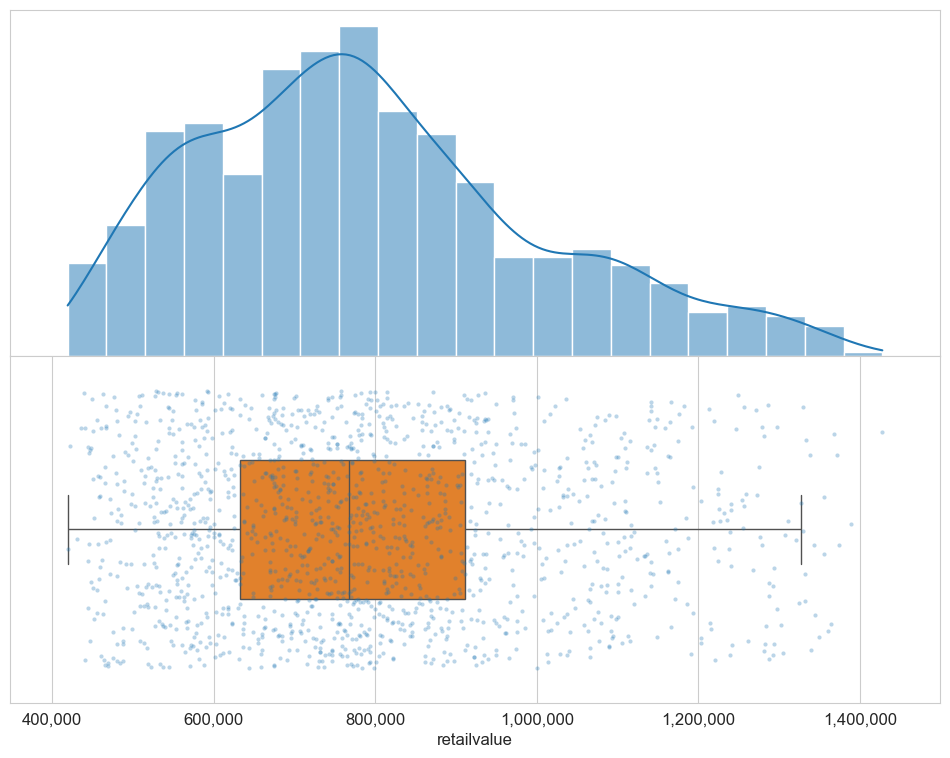

In [6]:
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    training_data["retailvalue"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    training_data["retailvalue"],
    orient="h",
    jitter=0.4,
    size=3,
    ax=axs[1],
    alpha=0.3
)

sns.boxplot(
    training_data["retailvalue"],
    orient="h",
    width=0.4,
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data["retailvalue"]) * 0.05
xmin = np.min(training_data["retailvalue"]) - spacer
xmax = np.max(training_data["retailvalue"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

plt.subplots_adjust(hspace=0)
axs[1].set_facecolor("white")
#remove scientific format
axs[1].xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))


In [7]:
#Summary statistics for price
training_data["retailvalue"].describe()

count       1,516.00
mean      791,773.75
std       211,424.32
min       419,000.00
25%       632,750.00
50%       768,000.00
75%       911,500.00
max     1,428,000.00
Name: retailvalue, dtype: float64

To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `retailvalue` in the training set is left-skew.

    False. The distribution is right-skewed, as the tail extends more to the right (towards higher values).
2.The mean of `retailvalue` in the training set is greater than the median.

   True. The mean is greater than the median, which is consistent with a right-skewed distribution.
3.75% of the houses in the training set sold for less than 911,250.00. euro

   True. The 75th percentile is 911,250.00 euro, which means that 75% of the houses sold for less than this amount.

If you have trouble answering the questions above, discuss them in class with each other and confirm with a TA

### 1.1.2 Retail Value vs House Area

Next, we examine `retailvalue` vs `house-area` (living area in m²).

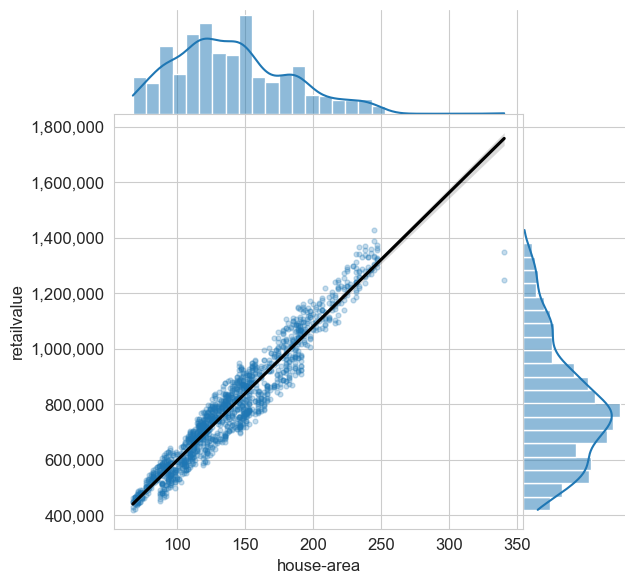

In [8]:
g= sns.jointplot(
    x="house-area",
    y="retailvalue",
    data=training_data,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={"s": 12, "alpha": 0.25},
    line_kws={"color": "black"}
)

g.ax_joint.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
g.ax_joint.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

We often expect a roughly linear relationship between size and value, but we should also look for unusual points (potential outliers). In this dataset, a small number of houses have house-area above 300 m². Let’s inspect them.

In [9]:
# q2house1 and q2house2 should be integers
q2house1 = training_data.loc[training_data["house-area"] > 300, "id"].iloc[0].item()
q2house2 = training_data.loc[training_data["house-area"] > 300, "id"].iloc[1].item()

q2house1, q2house2

(631929, 642836)

Below we write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable. For example, `remove_outliers(training_data, 'house-area', upper=300)` should return a data frame with only observations that satisfy `house-area` less than or equal to 300.

In [10]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


training_data = remove_outliers(training_data, "house-area", upper=300)

In [ ]:
#making sure the two observations were removed
assert training_data.shape[0] == 1514

### 1.1.3 Zipcode vs Retail Value

Next we explore this relationship. We have a small set of 4-digit zipcodes. Location is often one of the strongest predictors of housing value, so let’s inspect how values differ across zipcodes.

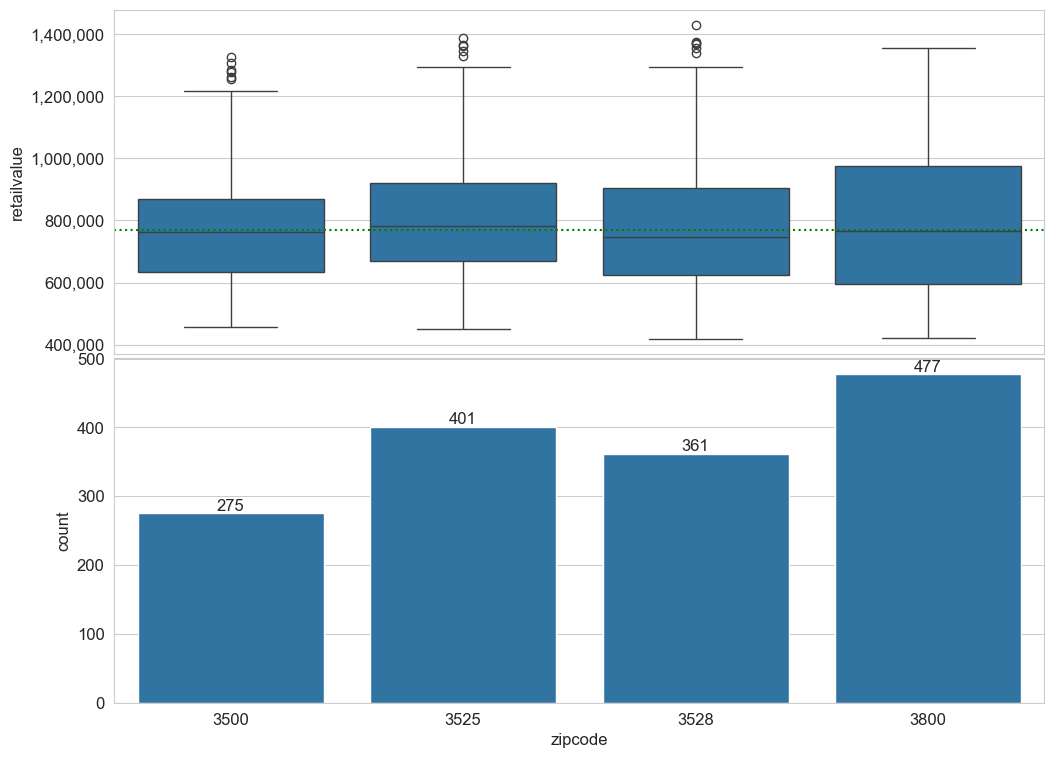

In [11]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x="zipcode",
    y="retailvalue",
    data=training_data.sort_values("zipcode"),
    ax=axs[0]
)

sns.countplot(
    x="zipcode",
    data=training_data.sort_values("zipcode"),
    ax=axs[1]
)

axs[0].axhline(
    y=training_data["retailvalue"].median(),
    color="green",
    linestyle="dotted"
)

for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f"{int(y)}", (x.mean(), y), ha="center", va="bottom")

axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.subplots_adjust(hspace=0.01)


What do you think? Are there differences or maybe outliers?

While the dataset includes a zipcode variable, these administrative boundaries are relatively coarse and may not fully capture finer-grained spatial patterns in housing prices. Homes that are geographically close to each other can belong to different zipcodes, while homes far apart may share the same zipcode. As a result, relying solely on zipcode may obscure important local effects related to accessibility, amenities, and neighborhood characteristics.

To better represent spatial structure in the data, we will create a new variable that groups houses into data-driven neighborhoods based directly on their geographic coordinates (`x-coor` and `y-coor`). Using a simple clustering technique, we partition the city into contiguous spatial regions that reflect natural groupings of properties. These spatial neighborhoods provide a more flexible and fine-grained representation of location than zipcode alone.

After constructing these spatial neighborhoods, we will identify the most expensive ones (based on median housing value) and create a binary indicator variable, `in_rich_neighborhood`, which marks whether a house lies in one of these high-value areas. 

This additional feature allows our models to incorporate local spatial effects more effectively and provides a useful lens for later fairness analysis, where we will examine whether prediction errors systematically differ across regions of the city.

In [12]:
from sklearn.cluster import KMeans

def add_spatial_neighborhoods(data, k=8, random_state=1983):
    data = data.copy()
    
    coords = data[["x-coor", "y-coor"]]
    
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    data["spatial_neighborhood"] = kmeans.fit_predict(coords)
    
    return data

In [13]:
training_data = add_spatial_neighborhoods(training_data, k=8)
training_data["spatial_neighborhood"].value_counts()

spatial_neighborhood
0    210
3    202
6    192
5    192
7    192
1    184
2    178
4    164
Name: count, dtype: int64

Text(0.5, 1.0, 'Data-driven Spatial Neighborhoods')

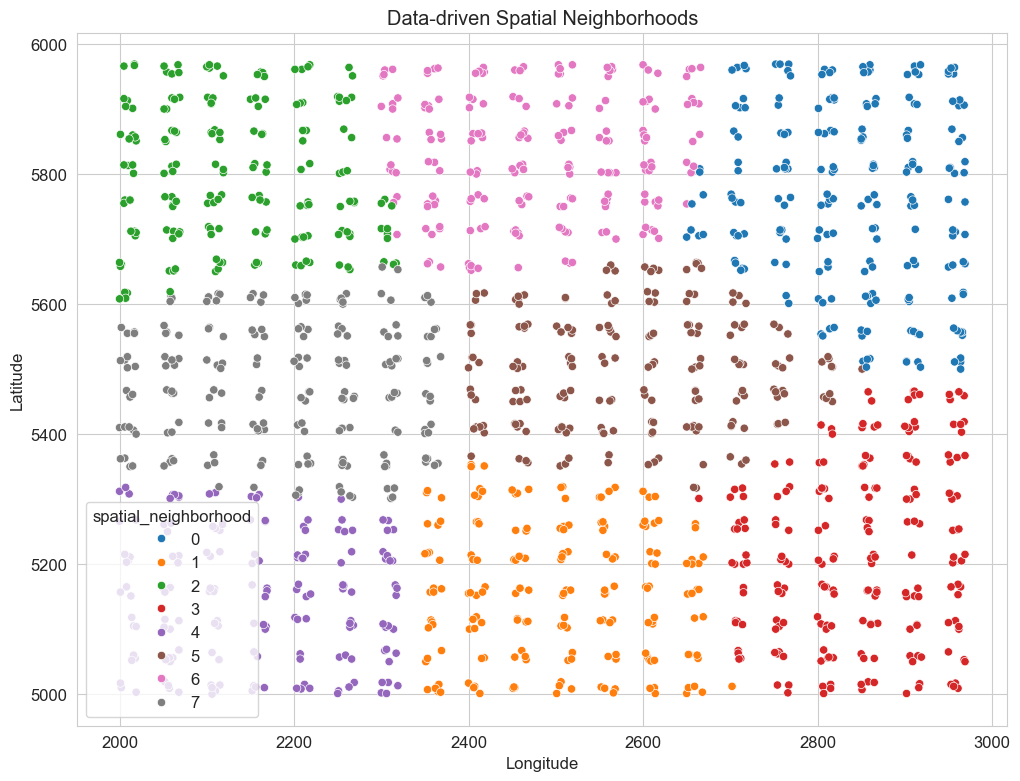

In [14]:
sns.scatterplot(
    x="x-coor",
    y="y-coor",
    hue="spatial_neighborhood",
    data=training_data,
    palette="tab10"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Data-driven Spatial Neighborhoods")


So now let's replot the previous figure but with this variable.

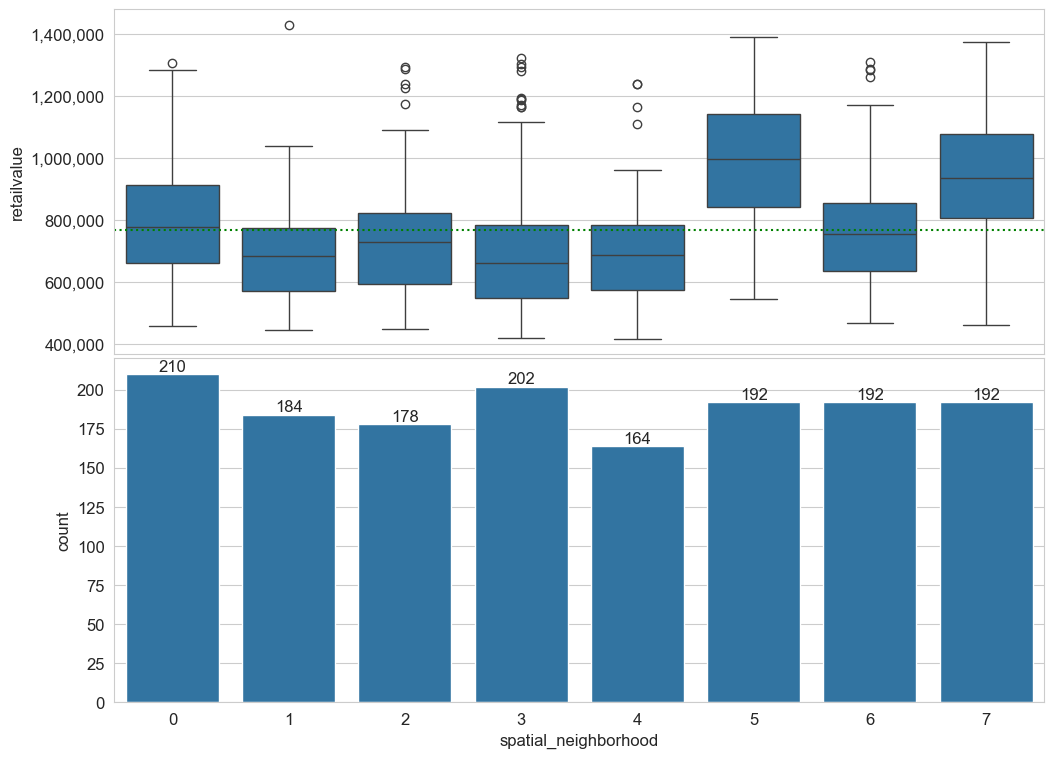

In [15]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x="spatial_neighborhood",
    y="retailvalue",
    data=training_data.sort_values("spatial_neighborhood"),
    ax=axs[0]
)

sns.countplot(
    x="spatial_neighborhood",
    data=training_data.sort_values("spatial_neighborhood"),
    ax=axs[1]
)

axs[0].axhline(
    y=training_data["retailvalue"].median(),
    color="green",
    linestyle="dotted"
)

for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f"{int(y)}", (x.mean(), y), ha="center", va="bottom")

axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.subplots_adjust(hspace=0.01)


Okay, now we managed to have some more variation and seems that in some cases retail values differ by the location and the number of observations is not identical across zipcodes.

Let's apply a simple binning trick and mark the top-3 locations by median retail value as “pricey neighborhoods”.

In [16]:
def find_pricey_neighborhoods(data, n=3, metric=np.median):
    """
    Returns a list of the top-n neighboorhoods by aggregated retailvalue (default: median).
    """
    tmp = data.groupby("spatial_neighborhood")["retailvalue"].agg(metric).sort_values(ascending=False)
    return tmp.head(n).index.tolist()

pricey_locs = find_pricey_neighborhoods(training_data, 3, np.median)
pricey_locs

/var/folders/6x/mwrlpd4905nc6vcdfmprmj3c0000gn/T/ipykernel_60991/48539376.py:5: FutureWarning: The provided callable <function median at 0x10a143ba0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  tmp = data.groupby("spatial_neighborhood")["retailvalue"].agg(metric).sort_values(ascending=False)


[5, 7, 0]

And we can add such a categorization to the dataset

In [17]:
def add_in_pricey_neighborhood(data, locs):
    """
    Adds a binary column in_pricey_neighborhoods:
      1 if location is in the provided list, else 0
    """
    data = data.copy()
    data["in_pricey_neighborhoods"] = data["spatial_neighborhood"].isin(locs).astype(int)
    return data

training_data = add_in_pricey_neighborhood(training_data, pricey_locs)
assert training_data["in_pricey_neighborhoods"].isnull().sum() == 0


In [18]:
training_data.head()

,id,zipcode,lot-len,lot-width,lot-area,house-area,garden-size,balcony,x-coor,y-coor,buildyear,bathrooms,taxvalue,retailvalue,energy-eff,monument,spatial_neighborhood,in_pricey_neighborhoods
818,473504,3500,15.10,8.50,128.40,191.25,26.40,1,2509,5864,2003,1,868000,969000,0,0,6,0
423,292120,3800,16.10,8.60,138.50,116.10,35.30,2,2613,5511,1973,1,575000,721000,0,0,5,1
296,233225,3525,11.20,6.50,72.80,87.75,7.80,0,2119,5802,2001,1,409000,480000,1,0,2,0
1739,882688,3525,14.00,10.60,148.40,190.80,42.40,1,2400,5662,1982,2,882000,1068000,1,1,6,0
1126,603592,3500,19.70,6.60,130.00,89.10,50.80,1,2966,5856,2001,1,460000,479000,1,0,0,1


In [19]:
# Which zipcodes are in the pricey spatial clusters?
training_data[training_data["spatial_neighborhood"].isin(pricey_locs)]["zipcode"].value_counts()

zipcode
3500    184
3800    173
3525    122
3528    115
Name: count, dtype: int64

Bonus (curiosity): Which are these expensive neighboorhoods in Utrecht?

the table above suggests that the zipcode with 3500, 3800,3525, 3528 are in the pricey spatial clusters.
Feel free to use (or adapt) this feature in your latter analysis.

## 1.2 Missing Data

Let's see if our data set has any missing values. 

👉 You should observe that there are no missing values in this dataset.

In [21]:
missing_counts = training_data.isnull().sum().sort_values(ascending=False)

assert isinstance(missing_counts, pd.Series)
assert missing_counts.size == training_data.shape[1]
assert set(missing_counts.index.values) == set(training_data.columns.values)

missing_counts

id                         0
zipcode                    0
spatial_neighborhood       0
monument                   0
energy-eff                 0
retailvalue                0
taxvalue                   0
bathrooms                  0
buildyear                  0
y-coor                     0
x-coor                     0
balcony                    0
garden-size                0
house-area                 0
lot-area                   0
lot-width                  0
lot-len                    0
in_pricey_neighborhoods    0
dtype: int64

## 1.3 Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.  When you move on to create your own model, you may want to try out more complex transformations.

### 1.3.1 House age

We’ll create a variable `house_age` based on `buildyear`. Since the dataset does not include a valuation year column, we’ll define age relative to a fixed reference year (2025 is fine for this dataset).

In [22]:
def add_house_age(data, reference_year=2025):
    data = data.copy()
    data["house_age"] = reference_year - data["buildyear"]
    return data

training_data = add_house_age(training_data)

In [26]:
# Check that no missing values were created
assert ~training_data["house_age"].isnull().any()

### 1.3.2 Total Outdoor Space

Outdoor space can matter a lot for price. We create:

```total_outdoor = lot-area + garden-size```

In [24]:
def add_total_outdoor(data):
    data = data.copy()
    data["total_outdoor"] = data["lot-area"] + data["garden-size"]
    return data

In [25]:
# Simple check
training_data = add_total_outdoor(training_data)
assert ~training_data["total_outdoor"].isnull().any()

#### Question 1 <a id="q1"></a>

Propose and justify at least two new features derived from existing variables.
Explain why they might improve predictive performance and how they could affect fairness.

(at this point we don't care if we are going to use them or not, we just make some hypothesis)

In [27]:
#code for feature 1
def add_value_per_sqm(data):
    data = data.copy()
    data["value_per_sqm"] = data["retailvalue"] / data["house-area"]
    return data

training_data = add_value_per_sqm(training_data)
training_data["value_per_sqm"].describe()

count   1,514.00
mean    5,721.36
std       473.25
min     4,704.76
25%     5,355.90
50%     5,712.00
75%     6,063.32
max     6,842.44
Name: value_per_sqm, dtype: float64

justification for feature 1 (predictive+fairness)

1. larger house dont always sell proportionally more, a 50m² apartment in the city center may cost more per m² than a 200m² house in the suburbs.
2. fairness: if the model systematically underestimates the value of smaller homes, it could lead to unfair tax burdens for residents of those homes. By including a feature that captures value per square meter, we can help ensure that our model accounts for this important aspect of housing valuation and does not disproportionately disadvantage certain groups of homeowners.

In [31]:
def add_old_monument(data):
    data = data.copy()
    data["is_old_monument"] = ((data["monument"] == 1) & (data["buildyear"] < 1970)).astype(int)
    return data

training_data = add_old_monument(training_data)
training_data["is_old_monument"].value_counts()

is_old_monument
0    904
1    610
Name: count, dtype: int64

justification for feature 2 (predictive+fairness)
1. predictive: Buildings that are both monuments and built before 1970 represent a distinct category: post-warII heritage properties (1945–1969 modernist/functionalist buildings) that have received protected status. These likely carry a different price premium than non-monument buildings or newer monuments. By creating a specific feature for this group, we can capture this unique effect on housing values more accurately.
2. fairness: If our model fails to account for the unique value of older monument properties, it may systematically undervalue them. This could lead to unfair tax assessments for owners of these historically significant homes. By including a feature that identifies old monuments, we can help ensure that our model treats these properties fairly and does not disproportionately disadvantage their owners.

# 2. Modeling

We’ve finally gotten to a point where we can specify a simple model. Since the Utrecht dataset is not pre-split into training and test files, we will create our own split. We will treat `utrechthousing.csv` as the complete dataset, use `train_test_split` to create `training_data` and `testing_data`, and then evaluate model performance on the test set.

As before, we will keep our preprocessing in reusable functions so we can apply the exact same pipeline to both training and testing data.

In [32]:
# Load a fresh copy of the data
full_data = pd.read_csv("utrechthousing.csv")

# Reproducible split
training_data, testing_data = train_test_split(full_data, test_size=0.2, random_state=1983)

# Sanity checks
assert training_data.shape == (1516, 16) #note that we are re-loading the dataset here and we apply pre-processing again later
assert testing_data.shape == (379, 16)
assert set(training_data.columns) == set(testing_data.columns)

Below we copy the functions we used before (you can add yours of course or modify them). Actually, we expect that you adapt this part for the next part (Question 5) but feel free to already adapt it here aswell.

In [33]:
from sklearn.cluster import KMeans

def select_columns(data, *columns):
    return data.reindex(columns=columns)

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]

def add_house_age(data, reference_year=2025):
    data = data.copy()
    data["house_age"] = reference_year - data["buildyear"]
    return data

def add_total_outdoor(data):
    data = data.copy()
    data["total_outdoor"] = data["lot-area"] + data["garden-size"]
    return data

def fit_spatial_neighborhood_model(train_data, k=8, random_state=1337):
    coords = train_data[["x-coor", "y-coor"]]
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(coords)
    return kmeans

def add_spatial_neighborhood(data, kmeans):
    data = data.copy()
    data["spatial_neighborhood"] = kmeans.predict(data[["x-coor", "y-coor"]])
    return data

def find_rich_spatial_neighborhoods(data, n=3, metric=np.median):
    # Top-n clusters by median retailvalue
    tmp = (
        data.groupby("spatial_neighborhood")["retailvalue"]
        .agg(metric)
        .sort_values(ascending=False)
    )
    return tmp.head(n).index.tolist()

def add_in_rich_neighborhood(data, rich_clusters):
    data = data.copy()
    data["in_rich_neighborhood"] = data["spatial_neighborhood"].isin(rich_clusters).astype(int)
    return data

def add_location_terms(data):
    """
    Adds simple nonlinear location terms to allow spatial curvature with linear models.
    """
    data = data.copy()
    data["x2"] = data["x-coor"] ** 2
    data["y2"] = data["y-coor"] ** 2
    data["xy"] = data["x-coor"] * data["y-coor"]
    return data
#add feature 1
def add_value_per_sqm(data):
    data = data.copy()
    data["value_per_sqm"] = data["retailvalue"] / data["house-area"]
    return data
#add feature 2
def add_old_monument(data):
    data = data.copy()
    data["is_old_monument"] = ((data["monument"] == 1) & (data["buildyear"] < 1970)).astype(int)
    return data

## 2.1 Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, this should be sufficient motivation to abstract parts of our code into reusable functions/methods.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model".

In [34]:
## 2.1 Reusable Pipeline

def select_columns(data, *columns):
    return data.reindex(columns=columns)

def process_data_gm1(data):
    # -------------------
    # Clean Data
    # -------------------
    data = remove_outliers(data, "house-area", upper=300)

    # -------------------
    # Transform Data
    # -------------------
    data = add_house_age(data)
    data = add_total_outdoor(data)

    # -------------------
    # Select modeling columns
    # -------------------
    data = select_columns(
        data,
        "retailvalue",
        "house-area",
        "bathrooms",
        "total_outdoor",
        "house_age",
        "balcony",
        "energy-eff",
        "monument"
    )

    # -------------------
    # Split predictors/target
    # -------------------
    X = data.drop(["retailvalue"], axis=1)
    y = data["retailvalue"]

    return X, y


An alternative way of writing the same code above explicitly allows us to think about our data flowing through a [pipeline](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html) where the output of one function is the input of the next.  Carefully thought out function names make the code self-documenting: you can just read off the intended high-level processing steps from top to bottom.

You are not required to use this style of coding.  We just wanted to point out that it exists.

In [35]:
def process_data_gm1(data):

    data = (
        data
        # -------------------
        # Clean Data
        # -------------------
        .pipe(remove_outliers, "house-area", upper=300)

        # -------------------
        # Transform Data
        # -------------------
        .pipe(add_house_age)
        .pipe(add_total_outdoor)

        # -------------------
        # Select columns
        # -------------------
        .pipe(select_columns,
              "retailvalue",
              "house-area",
              "bathrooms",
              "total_outdoor",
              "house_age",
              "balcony",
              "energy-eff",
              "monument")
    )

    X = data.drop(["retailvalue"], axis=1)
    y = data["retailvalue"]

    return X, y


## 2.2 Fitting our first model

We are finally going to fit a model (yay!). This part is slightly unceremonious since we did much of the heavy lifting in the previous sections. The model we will fit can be written as follows:

$$
\begin{align}
\text{retailvalue} =\;& \theta_0 
+ \theta_1 \times \text{HouseArea} 
+ \theta_2 \times \text{Bathrooms} \\
&+ \theta_3 \times \text{TotalOutdoor}
+ \theta_4 \times \text{HouseAge} \\
&+ \theta_5 \times \text{EnergyEfficiency}
+ \theta_6 \times \text{Monument}
+ \theta_7 \times \text{Balcony}
\end{align}
$$

where:

- `HouseArea` corresponds to `house-area`  
- `Bathrooms` corresponds to `bathrooms`  
- `TotalOutdoor = lot-area + garden-size`  
- `HouseAge = current year − buildyear`  
- `EnergyEfficiency` corresponds to `energy-eff`  
- `Monument` is an indicator for historic buildings  
- `Balcony` is an indicator for balcony presence  


#### Question 2a <a name="q1a"></a>
Remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_test`, or `y_test`.

In [36]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train,y_train = process_data_gm1(training_data)
X_test, y_test = process_data_gm1(testing_data)
guidedmodel1 = lm.LinearRegression(fit_intercept=True)


guidedmodel1.fit(X_train, y_train)
y_fitted = guidedmodel1.predict(X_train)
y_predicted = guidedmodel1.predict(X_test)

In [37]:
#print the result

print(y_fitted.mean())
print(y_predicted.mean())

791103.6988110965
785924.2617644883


In [38]:
#if you fail these, might still be okay (but good to check your model, split etc.)
assert 790000 <= y_fitted.mean() <= 8000000
assert 780000 <= y_predicted.mean() <= 790000

In [39]:
# Mean prediction should not be wildly off from mean actual target in training/test
assert abs(y_fitted.mean() - y_train.mean()) / y_train.mean() < 0.25
assert abs(y_predicted.mean() - y_test.mean()) / y_test.mean() < 0.25

In this assignment, we will use Root-Mean-Square Error (RMSE) to measure the quality of our models.  As a reminder, this quantity is defined as:

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in test set}}}$$

#### Question 2b <a name="q1b"></a>

Write a function `rmse` that calculates the RMSE of a model.  Again, make sure you are taking advantage of vectorized code.  This can be solved without any iteration.

In [40]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted) ** 2))

In [41]:
#print the error

rmse_value = rmse(y_test, y_predicted)
rmse_value

36952.05682081047

In [42]:
# RMSE should be smaller than the spread (std) of the target, otherwise the model is doing very poorly
assert rmse_value < y_test.std()
assert 35000 <= rmse(y_test, y_predicted) <= 37000

## 2.3 Checking our model: Residual Plots

Recall from the lectures that one way of diagnosing a model is through a residual plot. Here we plot the actual housing values (`retailvalue`) against the residuals of the model. Ideally, we would see a horizontal line of points at 0 (perfect prediction!). The next best outcome would be a roughly homogeneous cloud of points centered around 0.

However, since our first model is intentionally simple, we may observe systematic patterns in the residuals. In particular, it is common for linear models to underpredict very expensive homes and overpredict cheaper ones. Such patterns indicate that the model is underfitting and failing to capture more complex relationships in the data. You will likely want to address these issues when building your own final model in the open-response section.


Text(0, 0.5, 'Residuals (Actual Value - Predicted Value)')

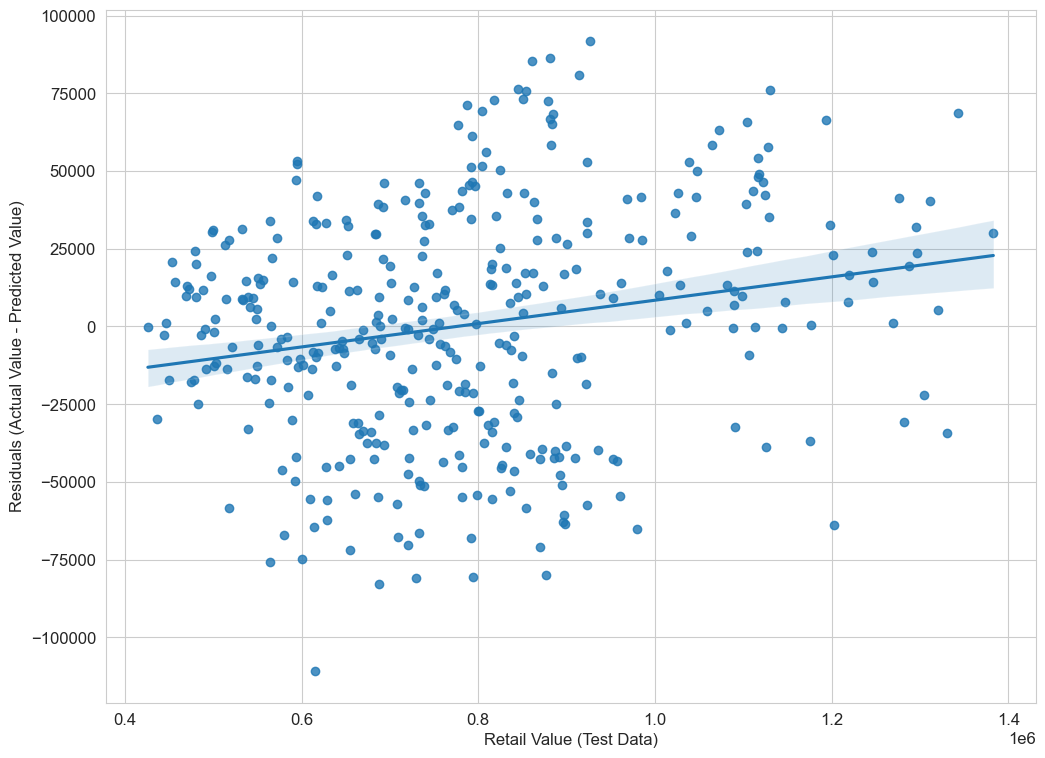

In [43]:
gm1_residuals = y_test - y_predicted

ax = sns.regplot(x=y_test, y=gm1_residuals)
ax.set_xlabel("Retail Value (Test Data)")
ax.set_ylabel("Residuals (Actual Value - Predicted Value)")

## 2.4 Regularizing our model

Ok, so let's make our modeling a little more fancy by regularizing the coefficients. This second model will use the Lasso, but you are free to use Ridge or other regularized linear models in your own work.

Before applying regularization, we need to standardize our predictor variables. This is necessary because regularization penalizes large coefficients, and variables measured on different scales would otherwise be treated unfairly. By standardizing each predictor to have mean 0 and standard deviation 1, we ensure that the penalty is applied consistently across features.

#### Question 3 <a name="q3"></a>

Write a function that standardizes the columns of a data frame containing only numeric columns.  Be sure to make use of vectorization.

In [45]:
def standardize_columns(data):
    '''
    Input:
      data (data frame): contains only numeric columns
    Output:
      data frame, the same data, except each column is standardized 
      to have 0-mean and unit variance
    '''
    std_col = (data-data.mean())/data.std()
    
    return std_col

In [46]:
# Simple test of the standardization function
test_standardize_df = standardize_columns(
    training_data[["retailvalue", "house-area"]])

# Make sure the mean is approximately zero
assert -0.001 < test_standardize_df.mean().sum() < 0.001

# Make sure the standard deviation is approximately one
assert 1.9 < test_standardize_df.std().sum() < 2.1


We will now define a new processing pipeline for our regularized model. This pipeline is similar to the one used for the simple linear regression model, except that we standardize the predictor variables before fitting the model.

In [47]:
def process_data_gm2(data):

    data = (
        data
        # -------------------
        # Clean Data
        # -------------------
        .pipe(remove_outliers, "house-area", upper=300)

        # -------------------
        # Feature engineering
        # -------------------
        .pipe(add_house_age)
        .pipe(add_total_outdoor)

        # -------------------
        # Select modeling columns
        # -------------------
        .pipe(select_columns,
              "retailvalue",
              "house-area",
              "bathrooms",
              "total_outdoor",
              "house_age",
              "balcony",
              "energy-eff",
              "monument")
    )

    # IMPORTANT: 
    # Standardize predictors (but not the target)
    # what will happen if we don't standardize?
    X = standardize_columns(data.drop(["retailvalue"], axis=1))
    y = data["retailvalue"]

    return X, y


It may be instructive to see the cross-validation procedure explicitly once.  You should be able to understand what each part of the code is doing below, but we do not expect you to use this code for your own model (use [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) instead).

In [48]:
# Process the data
X_train, y_train = process_data_gm2(training_data)
X_test, y_test = process_data_gm2(testing_data)

# Specify the model
guidedmodel2 = lm.Lasso(copy_X=True)

# Specify CV method and grid of regularization values
five_fold_cv = KFold(n_splits=5)
alphas = np.arange(0.001, 10, 0.5)

rmses = np.zeros(len(alphas))

# Grid search over alphas
for i, alpha in enumerate(alphas):
    guidedmodel2.set_params(alpha=alpha)
    model_rmse = 0

    for train_index, test_index in five_fold_cv.split(X_train):
        X_fold_train = X_train.iloc[train_index]
        y_fold_train = y_train.iloc[train_index]
        X_fold_test = X_train.iloc[test_index]
        y_fold_test = y_train.iloc[test_index]

        guidedmodel2.fit(X_fold_train, y_fold_train)
        y_fold_predicted = guidedmodel2.predict(X_fold_test)

        model_rmse += rmse(y_fold_test, y_fold_predicted)

    rmses[i] = model_rmse / 5

optimal_alpha = alphas[rmses == np.min(rmses)][0]

guidedmodel2.set_params(alpha=optimal_alpha)
guidedmodel2.fit(X_train, y_train)

y_predicted = guidedmodel2.predict(X_test)

print(f"The validation RMSE for this model with "
      f"alpha={optimal_alpha} is {rmse(y_test, y_predicted)}.")


The validation RMSE for this model with alpha=5.001 is 37449.687359081065.


### 2.4.1 Lasso Path

Let’s examine how RMSE varies across different values of the regularization parameter ($\lambda$ in lecture, `alpha` in `sklearn`). This is known as the regularization path. The dashed red line marks the value of `alpha` that minimizes RMSE.

Text(0, 0.5, 'RMSE')

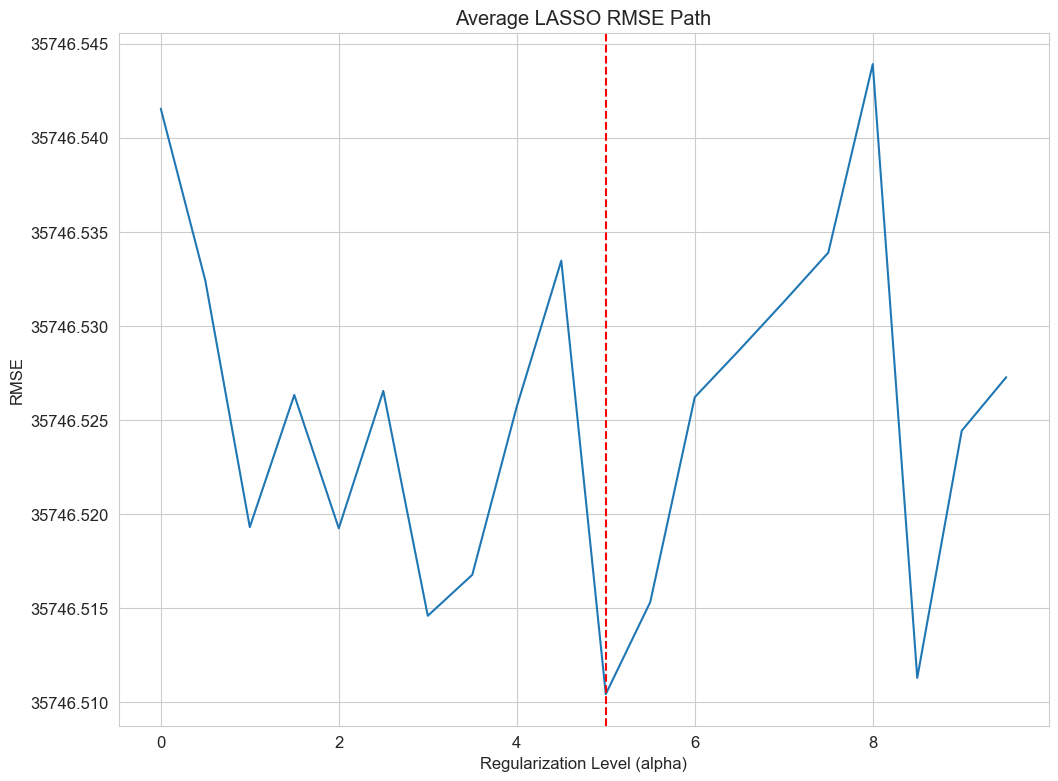

In [49]:
plt.plot(alphas, rmses)
plt.axvline(x=optimal_alpha, color="red", linestyle="dashed")

ax = plt.gca()
ax.set_title("Average LASSO RMSE Path")
ax.set_xlabel("Regularization Level (alpha)")
ax.set_ylabel("RMSE")


Alternative approach: You can also repeat the regularized regression using `LassoCV`, which automatically performs cross-validation over a grid of regularization values.


### 2.4.2 Lasso Residual Plot

Looking at the residual plot for our L1 regularized linear model, it's clear the regularization did not solve the problems we saw in the simple model.  It seems you have your work cut out for you!

Text(0, 0.5, 'Residuals (Actual Value - Predicted Value)')

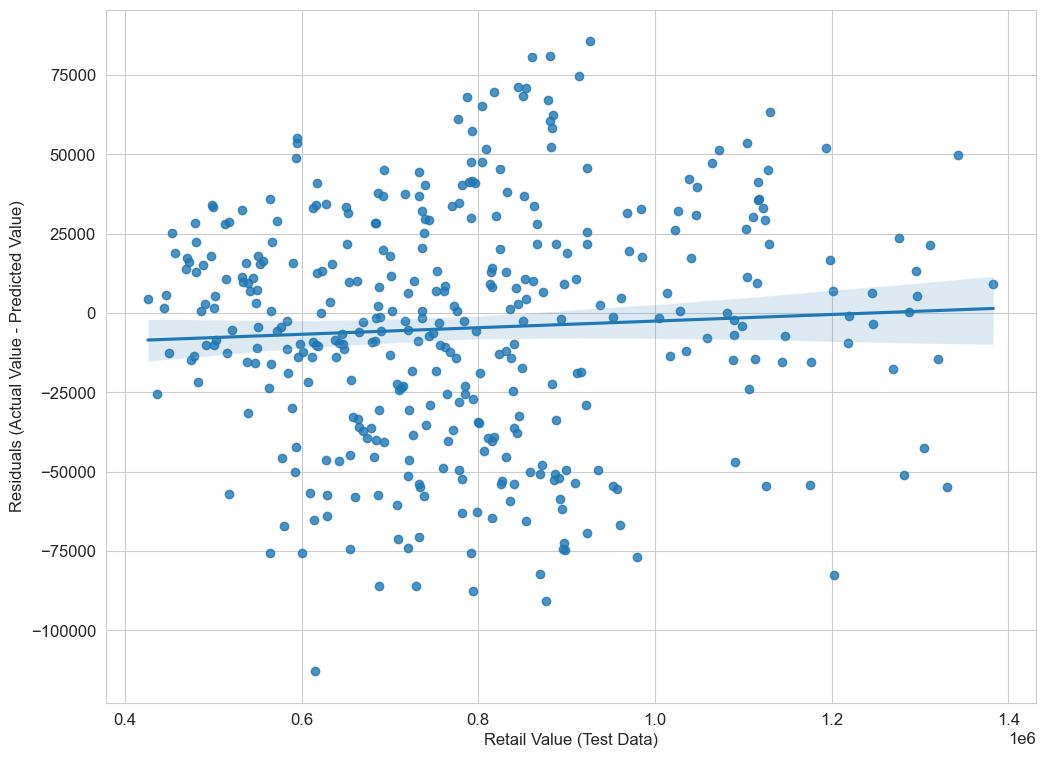

In [50]:
gm2_residuals = y_test - y_predicted

ax = sns.regplot(x=y_test, y=gm2_residuals)
ax.set_xlabel("Retail Value (Test Data)")
ax.set_ylabel("Residuals (Actual Value - Predicted Value)")


In [51]:
def process_data_gm2_location(data, kmeans_model=None, rich_clusters=None):
    data = (
        data
        .pipe(remove_outliers, "house-area", upper=300)
        .pipe(add_house_age)
        .pipe(add_total_outdoor)
        .pipe(add_location_terms)  # adds x2, y2, xy
    )

    # Add spatial neighborhood (fit only on training data)
    if kmeans_model is None:
        kmeans_model = fit_spatial_neighborhood_model(data)
    data = add_spatial_neighborhood(data, kmeans_model)

    if rich_clusters is None:
        rich_clusters = find_rich_spatial_neighborhoods(data, n=3)
    data = add_in_rich_neighborhood(data, rich_clusters)

    data = data.pipe(select_columns,
        "retailvalue",
        "house-area",
        "bathrooms",
        "total_outdoor",
        "house_age",
        "balcony",
        "energy-eff",
        "monument",
        "x2", "y2", "xy",
        "in_rich_neighborhood"
    )

    X = standardize_columns(data.drop(["retailvalue"], axis=1))
    y = data["retailvalue"]
    return X, y, kmeans_model, rich_clusters

Optimal alpha: 203.93913372464823
Test RMSE with location: 21272.10252674526
Test RMSE without location: 37449.687359081065


/var/folders/6x/mwrlpd4905nc6vcdfmprmj3c0000gn/T/ipykernel_60991/2532108958.py:34: FutureWarning: The provided callable <function median at 0x10a143ba0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  .agg(metric)


Text(0.5, 1.0, 'Residual Plot: Lasso with Location Features')

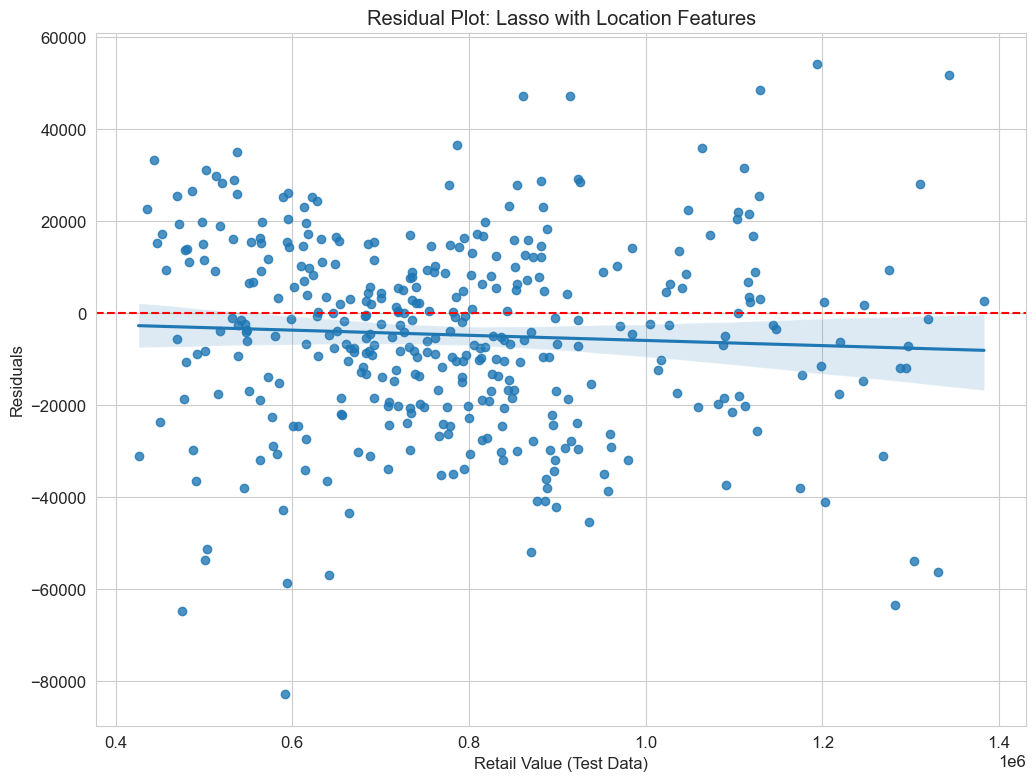

In [52]:
# Fit spatial model on training data only
kmeans_model = fit_spatial_neighborhood_model(training_data)
rich_clusters = find_rich_spatial_neighborhoods(
    add_spatial_neighborhood(training_data, kmeans_model), n=3
)

X_train_loc, y_train_loc, _, _ = process_data_gm2_location(
    training_data, kmeans_model, rich_clusters
)
X_test_loc, y_test_loc, _, _ = process_data_gm2_location(
    testing_data, kmeans_model, rich_clusters
)

gm2_loc = lm.LassoCV(cv=5, random_state=1983)
gm2_loc.fit(X_train_loc, y_train_loc)

y_pred_loc = gm2_loc.predict(X_test_loc)
print("Optimal alpha:", gm2_loc.alpha_)
print("Test RMSE with location:", rmse(y_test_loc, y_pred_loc))
print("Test RMSE without location:", rmse(y_test, y_predicted))  # from gm2

# Residual plot
residuals_loc = y_test_loc - y_pred_loc
ax = sns.regplot(x=y_test_loc, y=residuals_loc)
ax.axhline(y=0, color="red", linestyle="--")
ax.set_xlabel("Retail Value (Test Data)")
ax.set_ylabel("Residuals")
ax.set_title("Residual Plot: Lasso with Location Features")

In [55]:
#check for zero coefficients
coef_series = pd.Series(gm2_loc.coef_, index=X_train_loc.columns)
zero_coefs = coef_series[coef_series == 0]
print(f"Number of zero coefficients: {len(zero_coefs)}")
print("Zero coefficients:", zero_coefs.index.tolist())
print("\nAll coefficients (sorted by absolute value):")
print(coef_series.sort_values(key=np.abs, ascending=False))

Number of zero coefficients: 1
Zero coefficients: ['house_age']

All coefficients (sorted by absolute value):
house-area              190,203.98
x2                     -100,276.45
y2                      -67,792.46
xy                       59,739.02
total_outdoor            47,718.31
in_rich_neighborhood      6,627.20
balcony                   4,555.38
energy-eff               -3,425.75
monument                  3,279.07
bathrooms                 2,579.81
house_age                    -0.00
dtype: float64


#### Question 4

The following questions are supposed to hep you understand the impact of regularization.

4a) Does adding location features change the chosen `alpha` compared to the non-location model?

    Yes,  The alpha increased to ~204 compared to the non-location model. More features (especially correlated spatial ones like x2, y2, xy) require stronger regularization to prevent overfitting.

4b) Does the test RMSE improve?

    yes, it improved from 37450 to 21272, which is a greadt improvement,suggesting that the location features capture important spatial variation in housing values that the original model missed.

4c) How many coefficients become exactly zero? Which ones?

    only one, house_age, which suggests that after accounting for location, house age does not provide additional predictive value.

4d) Do you observe any signs of underfitting or overfitting in residual plots after adding location?

    The residual plot with location features shows a slight negative slop, which means the model still underpredicts expensive homes and overpredicts cheaper ones, but the pattern is less pronounced than in the non-location model. But there are no clear signs of overfitting, as the residuals are more tightly clustered around zero and show less systematic curvature compared to the original model. and from the obersrvation of the coefficients, the spatial features dominate the model, Feature like house-area has the strongest effect, followed by the spatial features (x2, y2, xy) and then the total_outdoor.
Note: Regularization thrives in cases where the dataset is messy (or when there are correlations with the features so it's fine if you don't observe strong effects as we saw in class

# 3. Let's improve the model, bring out the big guns...

In this part of the clinic, you are asked to go beyond the guided example and design your own predictive model.

You may use any **linear model** discussed in class (perhaps with non-linear polynomial features). Your goal is to **improve prediction performance** on unseen data, measured using **Root Mean Squared Error (RMSE)**.

---
### 📋 What you should do

1. Construct new features based on existing variables:
   - Spatial features (latitude, longitude, neighborhoods, clusters)
   - Polynomial features (e.g., squared terms, interactions)
   - Aggregated or transformed variables (e.g., total outdoor space, house age)
2. Select a set of predictors you believe will improve performance.
3. Build a reusable data processing pipeline (similar to the guided model).
4. Train a linear or regularized linear model using the training data.
5. Evaluate your model using RMSE on the test set.

You are encouraged to experiment and justify your modeling choices.

---

### ⚠️ Overfitting Check

- Models that perform extremely well on the training set but poorly on unseen data (we keep a set aside).
- You should aim for a balance between accuracy and generalization.

Using cross-validation and regularization is strongly recommended.

### Grading Scheme

Your model will be assessed based on:

- Predictive performance (RMSE)
- Soundness of your modeling pipeline
- Feature engineering choices (including polynomial features where appropriate)
- Evidence of avoiding overfitting
- Clear explanation of your approach

There is no single “correct” model — thoughtful experimentation is the goal.


#### Question 5 <a name="q3"></a>

Just as in the guided model above, you should encapsulate as much of your workflow into functions as possible.  Define `process_data_fm` and `final model` in the cell below. In order to calculate your final model's RMSE, we will run the code in the cell after that.

In [ ]:
# =========================
# Solution to Open-Response 
# =========================

#import numpy as np
#import pandas as pd

#from sklearn import linear_model as lm
#from sklearn.model_selection import train_test_split
#from sklearn.cluster import KMeans


# -------------------------
# Utility functions (e.g. rmse)
# -------------------------


# -------------------------
# Feature engineering (everything you carry from parts 1 and 2)
# -------------------------

In [ ]:
# -------------------------
# Final processing pipeline (feel free to ingore but is handy to use)
# -------------------------
def process_data_fm(data):#zipcode_categories, kmeans_model, k_clusters=10):
#you might modify this if needed e.g. see below if you use the kmeans exampe or other input
#def process_data_fm(data) #zipcode_categories, kmeans_model, k_clusters=10):
    """
    Final model processing:
      - Clean: outliers
      - Transform: engineered features
      - Encode: zipcode + spatial cluster
      - Standardize: predictors
      - Return: X, y
    """
# code here
 
    return X, y

In [ ]:
# =========================
# Train/test split (single file)
# =========================
#reloading the data jst in case, same train/test spit
full_data = pd.read_csv("utrechthousing.csv")
training_data, testing_data = train_test_split(full_data, test_size=0.2, random_state=1983)

# pre-process data
#X_train, y_train = process_data_fm(training_data)
#X_test, y_test = process_data_fm(testing_data)

# ============================
# Final model (the big winner)
# ============================
# final_model = ...

# final_model.fit(X_train, y_train)

# Evaluate
#y_pred_train = final_model.predict(X_train)
#y_pred_test = final_model.predict(X_test)

#training_score = rmse(y_train, y_pred_train)
#test_score = rmse(y_test, y_pred_test)

#print("Chosen alpha:", final_model.alpha_)
#print("Chosen l1_ratio:", final_model.l1_ratio_)
#print("Training RMSE:", training_score)
#print("Test RMSE:", test_score)

# Optional: see which features survived regularization
#coef = pd.Series(final_model.coef_, index=X_train.columns).sort_values(key=np.abs, ascending=False)
#print("\nTop coefficients by absolute value:")
#print(coef.head(15))

#something else?

In [ ]:
#training_data = pd.read_csv('ames_train.csv')
#X_train, y_train = process_data_fm(training_data)
#final_model.fit(X_train, y_train)

## 4. Assessing Feature Importance via Perturbation Tests

So far, we have evaluated our models using prediction error. However, understanding **which features drive predictions** is equally important — especially when models are used in socially sensitive contexts such as housing valuation.

One intuitive way to assess feature importance is through a **perturbation (permutation) test**. The idea is simple (and we discussed it in class after regularization - so refer to the slides of Chapter/Lecture VI as well):

> If a feature is important, randomly shuffling its values should significantly worsen model performance.

This breaks the relationship between the feature and the target while keeping the rest of the data unchanged.

---

### 🔍 Intuition

- Small change in RMSE → feature not very important  
- Large increase in RMSE → feature highly influential  

---

### 📋 Procedure

1. Measure the original model RMSE on the test set  
2. For each feature:
   - Shuffle its values in the test data  
   - Recompute RMSE  
   - Record the increase in error  

### Question 6

Implement a perturbation test to estimate the importance of each feature in your model.

Answer the following questions:

- Which features appear most influential?
- Are any features surprisingly unimportant?
- (include any other interesting observation you make)

Reflect briefly on what this means for both prediction performance and fairness. 


In [ ]:
def perturbation_importance(model, X_test, y_test, metric=rmse):
    """
    Computes feature importance via perturbation tests.
    
    Returns a Series indexed by feature name with RMSE increase values.
    """
    
    return []


In [ ]:
# 1) Make sure we use the model that was actually fit
# (final_model was fit on X_train from process_data_fm)
model = final_model

# Align feature columns (protects against column order / missing dummies / extra columns)
#X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

feature_importance = perturbation_importance(
    model, 
    X_test, 
    y_test
)

feature_importance


In [ ]:
plt.figure(figsize=(10,6))
feature_importance.plot(kind="bar")
plt.ylabel("Increase in RMSE after perturbation")
plt.title("Feature Importance via Perturbation Test")
plt.show()


### ** Analysis and answers to questions goes here**

more text goes here

## 5. Assessing Fairness Through Error Analysis Across Locations

High predictive accuracy does not necessarily imply a fair model. In housing valuation, systematic over- or under-estimation in certain areas may disproportionately affect specific communities.

To explore potential fairness issues, we examine whether prediction errors differ across geographic groups, such as zip codes or spatial neighborhoods.

If the model consistently:

- Overestimates values in some areas
- Underestimates values in others

this may indicate unequal treatment depending on the location your house is in.

---

### 📋 Procedure

1. Compute prediction errors for each house:
   
   Error = Actual Value − Predicted Value  

2. Group errors by geographic category (e.g., zip code or spatial cluster)

3. Compare average error and RMSE across groups

---

### Question 7

Analyze whether prediction errors differ systematically across locations.

Answer the following:

- Are some neighborhoods consistently overvalued or undervalued?
- Which areas show the largest prediction errors?
- What might explain these patterns?

(any other observation you think is worth mentioning)

In [ ]:
# Might be handy to create a results DataFrame
fairness_df = testing_data.copy()

fairness_df["prediction"] = y_pred_test
fairness_df["error"] = fairness_df["retailvalue"] - fairness_df["prediction"]
fairness_df["abs_error"] = np.abs(fairness_df["error"])


In [ ]:
# compute the error per-zipcode (hint: use groupby and agg?)

In [ ]:
#plot figure and show any differences?

### ** Analysis and answers to questions goes here**

more text goes here